### Preprocessing

In [7]:
import csv

filename = 'training_dataset.csv'

data = []
header = []
# read data
with open(filename, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    
    for i, row in enumerate(reader):
	# skip header line
        if i == 0:
            header = row
        data.append(row)
# sort w.r.t ship_ids
shipids = [x[0] for x in data]
ind = [i[0] for i in sorted(enumerate(shipids), key=lambda x:x[1])]
sortedData = [data[ind[i]] for i in range(len(data))]

with open('sorted_' + filename, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for dat in sortedData:
        writer.writerow(dat)
        


# convert timestamps to numerical values

# not working because of timestamp datatype
def isSorted(data):
    for i in range(len(data) - 1):
        if data[i][0] == data[i + 1][0] and (not data[i][7] < data[i + 1][7]):
            print(i)
            print(data[i][0], data[i + 1][0])
            print(data[i][7], data[i + 1][7]) # should be numerical
            return False
    return True
        


In [9]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Apr  7 16:11:10 2018

@author: melih
"""

import csv

filename = 'sorted_training_dataset.csv'

data = []
header = []
# read data
with open(filename, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    
    for i, row in enumerate(reader):
	# skip header line
        if i == 0:
            header = row
            continue
        data.append(row)

transactional_data = []
# first data's departure port
depart = data[0][8]
ship_id = data[0][0]
transaction_id = 1
i = 0
for entry in data:
    if (entry[11] == ''): # drop missing rows for arrival port
        continue
    if (entry[6] == ''): # drop missing rows for heading
        continue
    if entry[8] != depart or entry[0] != ship_id: # if transaction changes
        transaction_id += 1
        depart = entry[8]
        ship_id = entry[0]
    transaction_entry = [transaction_id] + entry[1:] #remove ship_id
    transactional_data.append(transaction_entry)

with open('Dataset/preprocess_outputs/transactional_labeled.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(header)
    for dat in transactional_data:
        writer.writerow(dat)
      


plot


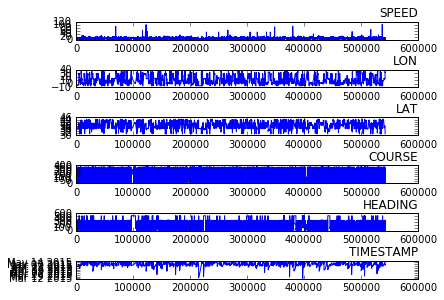

In [4]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

# Load Dataset
def parse(timestamp):
    date = ''
    format_type = True if len(timestamp.split('-')) > 1 else False
    if format_type:
        try:
            date = datetime.strptime(timestamp, "%d-%m-%y %H:%M")
        except Exception as e:
            print("Got Exception 1: ", timestamp)
    else:
        try:
            date = datetime.strptime(timestamp, "%d/%m/%Y %H:%M")
        except Exception as e:
            print("Got Exception 2: ", timestamp)

    return date

dataset_path  = 'Dataset/training_dataset.csv' ## apply on transactional_labeled.csv
df = read_csv(dataset_path,  parse_dates = ['TIMESTAMP'], index_col=False, date_parser=parse)
df.drop('SHIPTYPE', axis=1, inplace=True)
df.drop('ARRIVAL_PORT_CALC', axis=1, inplace=True)
#df.drop('ARRIVAL_CALC', axis=1, inplace=True)
df.drop('REPORTED_DRAUGHT', axis=1, inplace=True)
df.drop('DEPARTURE_PORT_NAME', axis=1, inplace=True)


# manually specify column names
df.columns = ['SHIP_ID', 'SPEED', 'LON', 'LAT', 'COURSE', 'HEADING', 'TIMESTAMP', 'ARRIVAL_PORT_CALC']
dataset = df.sort_values(by=['SHIP_ID', 'TIMESTAMP'])
dataset.drop('SHIP_ID', axis=1, inplace=True)

# save to file
dataset.to_csv('Dataset/preprocess_outputs/arrival_calc_processed.csv', index=False)

values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
print('plot')
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.tight_layout(pad=0.1)
    pyplot.title(dataset.columns[group], y=1.0, loc='right')
    i += 1
pyplot.show()


### LSTM

Using TensorFlow backend.


(430800, 1, 6) (430800,) (107787, 1, 6) (107787,)
Train on 430800 samples, validate on 107787 samples
Epoch 1/1
68s - loss: 0.0798 - val_loss: 0.0967


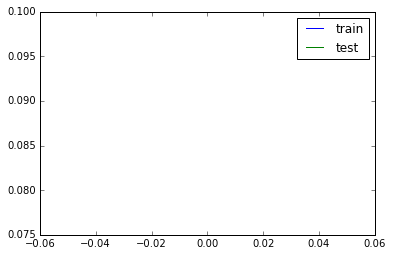

Test Score: 0.10 MSE (0.31 RMSE)


In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math

dataset_path = 'Dataset/preprocess_outputs/arrival_calc_processed.csv'


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


if __name__ == "__main__":
    dataset = read_csv(dataset_path)
    # integer encode direction
    encoder = LabelEncoder()
    dataset = dataset.dropna(axis=0, how='any')
    values = dataset.values
    values[:, 6] = encoder.fit_transform(values[:, 6])
    values[:, 5] = encoder.fit_transform(values[:, 5])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    # reframed = series_to_supervised(scaled, 1, 1)

    # values = reframed.values
    values = scaled
    train = values[:80 * (len(values) / 100), :]
    test = values[80 * (len(values) / 100):, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=1, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                        shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # make a prediction
    testScore = model.evaluate(test_X, test_y, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))


# NAIVE BAYES & KNN

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# ! pip install --upgrade pip
# ! pip install -U comb
# ! pip install -U scikit-learn
import sklearn 
print(sklearn.__version__)
from __future__ import print_function
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

dataset_path  = 'Dataset/preprocess_outputs/port_calc_processed.csv'

if __name__ == "__main__":

    dataset = read_csv(dataset_path)
    # integer encode direction
    encoder = LabelEncoder()
    dataset = dataset.dropna(axis=0, how='any')
    values = dataset.values
    values[:, 5] = encoder.fit_transform(values[:, 5])
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values[:,[0,1,2,3,4,5]])

    values[:,[0,1,2,3,4,5]] = scaled

    # dividing X, y into train and test data
    X_train, X_test, y_train, y_test = train_test_split(values[:,[0,1,2,3,4,5]], values[:,6], random_state=0)

    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
    # accuracy on X_test
    accuracyKNN = knn.score(X_test, y_test)
    print(accuracyKNN)

    # -----------------------------------------------------
    # from sklearn.svm import SVC
    # svm_model_linear = SVC(kernel='linear', C=1).fit(X_train, y_train)
    # svm_predictions = svm_model_linear.predict(X_test)
    # # model accuracy for X_test
    # accuracySVM = svm_model_linear.score(X_test, y_test)
    # print(accuracySVM)

    # -----------------------------------------------------

    # training a Naive Bayes classifier
    from sklearn.naive_bayes import GaussianNB

    gnb = GaussianNB().fit(X_train, y_train)
    gnb_predictions = gnb.predict(X_test)

    # accuracy on X_test
    accuracyNB = gnb.score(X_test, y_test)
    print(accuracyNB)

0.18.2


/Users/mesutgurlek/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


0.968799898995
0.343349647597


### CNN 

In [4]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  8 02:18:32 2018

@author: melih
"""

import pandas as pd
import numpy as np
from itertools import groupby
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

def get_counts(data):
    '''Returns total nnumber of transactions and data'''
    transaction_ids = set()
    ship_ids= data.loc[:, 'SHIP_ID'].tolist()
    [transaction_ids.add(x) for x in ship_ids]
    return len(transaction_ids), len(ship_ids)

def labels2onehot(labels):
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(labels)
    encoded_Y = encoder.transform(labels)
    # convert integers to dummy variables (i.e. one hot encoded)
    return np_utils.to_categorical(encoded_Y)

class Transaction_Reader():
        
    def __init__(self, file):
        self.data = pd.read_csv(file)
        self.batch = None
        self.total_transactions,total_data = get_counts(self.data)
        self.current_idx = 0
        self.current_batch = -1
        self.ship_ids = self.data.loc[:, 'SHIP_ID'].tolist()
        self.trans_freqs = [len(list(group)) for key, group in groupby(self.ship_ids)]
        self.labels_onehot = labels2onehot(self.data.loc[:, 'ARRIVAL_PORT_CALC'])
        
    def next_batch(self):
        ''' Returns rows of next transaction as 2-d numpy array'''
        self.current_batch += 1
        if self.current_batch >= self.total_transactions:
            return None
        next_idx = self.trans_freqs[self.current_batch]
        X = self.data.loc[self.current_idx:self.current_idx + next_idx - 1, 'SPEED':'HEADING']
        y = self.labels_onehot[self.current_idx:self.current_idx + next_idx - 1]
        self.current_idx += next_idx
        return np.array(X), np.array(y)
        
    def hasnext_batch(self):
        return self.current_batch < self.total_transactions
    

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
sns.despine()

get_ipython().magic(u'matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')

file = ('Dataset/preprocess_outputs/port_calc_processed.csv')

WINDOW = 50
EMB_SIZE = 5
STEP = 20
FORECAST = 1
train_percentage = 0.8
val_percentage = 0.1

reader = Transaction_Reader(file)

X_train, X_test, X_val, Y_val, Y_train, Y_test = [], [], [], []
x_train_count = int(reader.total_transactions * train_percentage)
x_val_count = int(reader.total_transactions * train_percentage)
for j in range(reader.total_transactions):
    data, labels = reader.next_batch()
    for i in range(0, reader.trans_freqs[reader.current_batch], STEP):
        try:
            x_i = data[i:i+WINDOW]
            y_i = labels[i+WINDOW]
        except Exception as e:
            break
        if reader.current_batch <= x_train_count:
            X_train.append(x_i)
            Y_train.append(y_i)
        elif reader.current_batch > x_train_count and current_batch <= x_train_count + x_val_count:
            X_val.append(x_i)
            Y_val.append(y_i)
        else:
            X_test.append(x_i)
            Y_test.append(y_i)
    
X_train, X_val, X_test, Y_train, Y_val, Y_test = np.array(X_train), np.array(X_val), np.array(X_test), np.array(Y_train), np.array(Y_val), np.array(Y_test)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_val = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

no_class = Y_train.shape[1]

model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=16,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=8,
                        filter_length=4,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(no_class))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="multivariate.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, 
          nb_epoch = 100, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_val, Y_val),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

model.load_weights("multivariate.hdf5")
pred = model.predict(np.array(X_test))

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyError: u'the label [SHIP_ID] is not in the [columns]'